In [1]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage
import neurokit2 as nk
import pandas as pd
from scipy.signal import iirnotch, lfilter, butter
import scipy
from scipy.fft import fft
from scipy.signal import find_peaks, peak_prominences
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline


dataset_path= "electrocardiogram-skin-conductance-and-respiration-from-spider-fearful-individuals-watching-spider-video-clips-1.0.0"

sampling_rate = 100

In [2]:
# to get the list of directories in the specified directory.
onlydirs = [f for f in listdir(dataset_path) if isdir(join(dataset_path, f))]
#print(onlydirs)
print(len(onlydirs))

#subject's folder in the list
#sub_ind = 14
print("Looking at patient: ", onlydirs[0])

# read triggers file
csvpath = dataset_path+'/'+onlydirs[0]+'/Triggers.txt'
info = np.loadtxt(csvpath,dtype='str')
print(len(info))
print(info)

57
Looking at patient:  VP05
19
[['CLIP-DEMO' '111900' '112010']
 ['CLIP-1' '112055' '112156']
 ['CLIP-4' '112224' '112324']
 ['CLIP-3' '112353' '112454']
 ['CLIP-2' '112522' '112622']
 ['CLIP-5' '112732' '112832']
 ['CLIP-7' '112856' '112956']
 ['CLIP-6' '113017' '113118']
 ['CLIP-8' '113134' '113234']
 ['CLIP-11' '113423' '113524']
 ['CLIP-10' '113544' '113645']
 ['CLIP-12' '113706' '113807']
 ['CLIP-9' '113837' '113937']
 ['CLIP-15' '114028' '114129']
 ['CLIP-16' '114151' '114252']
 ['CLIP-13' '114310' '114411']
 ['CLIP-14' '114426' '114527']
 ['BIOFEEDBACK-OXYGEN-TRAININGS' '111712' '114603']
 ['BIOFEEDBACK-REST' '114800' '115301']]


In [3]:
def RR_data(sub_ind):
    # read prespiration file
    csvpath = dataset_path+'/'+onlydirs[sub_ind]+'/BitalinoBR.txt'
    # load the txt file
    data = np.loadtxt(csvpath,dtype='str')

    # respiratory recording
    RR = data[:,0].astype(float)
    # timestamps
    RR_time = data[:,1].astype(float)

    return RR, RR_time



###### Display correct section of Respiration Rate Data



    
def clip_range(sub_ind, clip_number, RR_time, min_time, max_time):
    #clip to be displayed
    
    
#    print(min_time, max_time)
    

    min_index = 0.0
    max_index = 0.0
    for k in range(0,len(RR_time)):
        if(float(RR_time[k]) < min_time):
            min_index = int(k)
            
    for j in range(len(RR_time)-1,-1,-1):
        if(float(RR_time[j]) > max_time):
            max_index = int(j)

    #print(info[clip_number][0])
    #print(RR_time[min_index],RR_time[max_index])

    return min_index, max_index


#RR, RR_time = RR_data(0)
#min_time = float(info[0][1])
#max_time = float(info[0][2])
#print(min_time, max_time)
#min_index, max_index = clip_range(0,0,RR_time, min_time, max_time)
#print(min_index, max_index)

In [4]:

def generate_RR(sub_ind, clip_number, min_index, max_index, RR):

    #print(min_index, max_index)
    #print(len(RR))
    RR = RR[min_index:max_index]
    
    t = np.arange(0,RR.size*0.01,0.01)
    t = t[:RR.size]

    RR = (RR- np.mean(RR))/np.std(RR)

    ############ Signal filtering in order to make it smooth
    Fs = sampling_rate 
    order = 4 
    frequency = 10
    frequency = frequency/(Fs/2)
    b, a = scipy.signal.butter(order, frequency, btype='low')
    RR_lp = scipy.signal.filtfilt(b, a, RR)


    size= int(0.75*Fs)
    RR_sm0 = scipy.ndimage.uniform_filter1d(RR_lp, int(size), mode='nearest') 

    kernel="parzen"
    window = scipy.signal.get_window(kernel, 150) 
    w = window / window.sum()

    firstvalue = np.repeat(RR_sm0[0], 50)
    lastvalue = np.repeat(RR_sm0[-1], 100)
    eda_sm0 = np.concatenate((firstvalue, RR_sm0, lastvalue))

    RR_sm = np.convolve(w, RR_sm0, mode='same')
    RR_sm = RR_sm[size:-size]

    ## High Pass filter to remove the unwanted low frequencies below 0.05 Hz which result in a breathing rate of 3 Breaths per minute
    ## Minimum number of breaths are 12 breaths per minute (https://www.healthline.com/health/normal-respiratory-rate#normal-rate-in-kids)




    #Find Respiration Rate through FFT
    Y = np.abs(fft(RR_sm))
    F = np.arange(0,sampling_rate,sampling_rate/np.size(Y))
    F = F[:len(Y)]

    RR_bw = F[np.argmax(Y)]*60
    #print('Respiration Rate:',RR)


    ####### Plot Signal

    t = t[:len(RR_sm)]

    
#     plt.figure(figsize=(30,8))

#     plt.subplot(1,2,1)
#     plt.plot(t,RR_sm)
#     plt.xlabel('$Time (s)$') 
#     plt.ylabel('Amplitude') 
#     plt.title('Respiration Rate Signal')

#     plt.subplot(1,2,2)
#     plt.plot(F,Y)
#     plt.plot(F[np.argmax(Y)], Y[np.argmax(Y)], 'o', color = "red")
#     plt.text(F[np.argmax(Y)], Y[np.argmax(Y)], '({}, {})'.format( round(F[np.argmax(Y)],2), round(Y[np.argmax(Y)],0)))
#     plt.xlabel("Frequency $(Hz)$")
#     plt.ylabel("Amplitude")
#     plt.title("FFT of Respiration Rate")
    #plt.xlim([0,2])
    
    
    return RR_sm

#RR_function = generate_RR(0, 0, min_index, max_index, RR)

In [52]:
#One Respiration is one chest rise. Distance between peaks is studied

def measure_RR(function, is_RR_data):
    ##Bandpass filter of 0.083 Hz - 0.5 Hz = 5 - 30  BPM
    order=10
    freqs=[0.083,0.5]
    sos = scipy.signal.butter(order, freqs, btype='bandpass', output="sos", fs= sampling_rate)
    function= scipy.signal.sosfiltfilt(sos, function)



    ##Found all peaks and troughs of the signal
    peaks, _ = find_peaks(function)
    troughs, _ = find_peaks(-function)

    peak_prominence = np.absolute(peak_prominences(function, peaks)[0])
    trough_prominence = np.absolute(peak_prominences(-function, troughs)[0])

    vert_diff = np.hstack((peak_prominence,trough_prominence))

    ##Determine third quartile and threshold: 0.3 * Q3

    if(is_RR_data == True):
        a = 0.1
    else:
        a = 0.3
    
    threshold = a * np.percentile(vert_diff, 75)

    ##Remove peaks whose difference is smaller than threshold

    for i in range(len(peaks)):
        if (vert_diff[i] < threshold):
            peaks[i] = 0

    k = 0
    j = len(peaks)
    i = 0
    while i < j:
        if(peaks[i-k] == 0):
            peaks = np.delete(peaks,i-k)
            k = k + 1
        i = i + 1

    ##Calculate adjacent time intervals
    t_intervals = np.asarray([])

    for i in range(1,len(peaks)):
        t_intervals = np.append(t_intervals, (peaks[i] - peaks[i-1])/sampling_rate)
    
    #print(peaks)
    #print(t_intervals)

    calc_RR = 60/np.mean(t_intervals)
    
    t=np.arange(0,function.size*0.01,0.01)
    t=t[:ecg.size]

    plt.figure(figsize=(14,5))
    plt.plot(peaks*0.01, function[peaks], "o")
    plt.plot(t, function)
    plt.title("Respiration Rate Prediction - Baseline Wandering")
    plt.xlabel("Time $(s)$")
    plt.ylabel("Amplitude")
    plt.savefig("New RR Method.png")
    #plt.title(str(is_RR_data))
    plt.show()
    
    return calc_RR


    
#measure_RR(RR_function, True)

In [53]:
def generate_ecg(sub_ind, clip_number, min_index, max_index):

    # read ecg file
    csvpath = dataset_path+'/'+onlydirs[sub_ind]+'/BitalinoECG.txt'
    # load the txt file
    data = np.loadtxt(csvpath,dtype='str')
    # ecg recording
    ecg = data[:,0].astype(float)
    # timestamps
    ecg_time = data[:,1].astype(float)


    ecg = ecg[min_index:max_index]
    t=np.arange(0,ecg.size*0.01,0.01)
    t=t[:ecg.size]


    ## Notch filter to remove 40 - 50 Hz from the mains
    nyq = 0.5*sampling_rate
    notch=50
    notch = notch/nyq
    b, a = iirnotch(notch, 30, fs=sampling_rate)
    ecg = lfilter(b,a,ecg)


    t = t[:len(ecg)]
#     plt.figure(figsize=(12,4))
#     plt.plot(t,ecg)
#     plt.xlabel('$Time (s)$') 
#     plt.ylabel('Amplitude') 
#     plt.title('ECG Signal')
#     plt.xlim([0,10])

    return ecg

#ecg = generate_ecg(0,0, min_index, max_index)

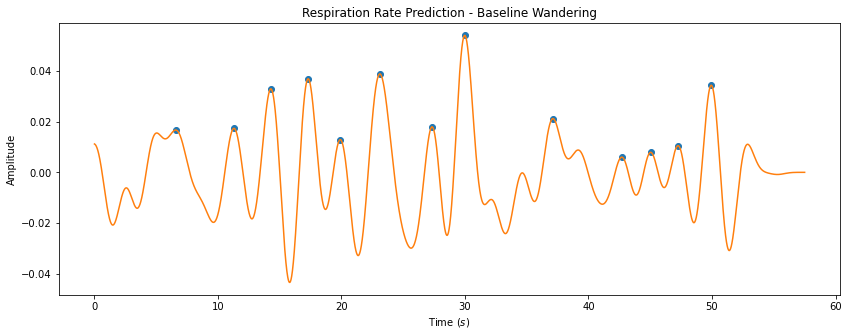

In [54]:
def generate_bw(sub_ind, clip_number, ecg):

    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)

    signal_dwt, waves_dwt = nk.ecg_delineate(ecg, 
                                          rpeaks, 
                                          sampling_rate=100, 
                                           method="cwt", 
                                 show_type='peaks')


    ## Focus on ECG Q Peaks from the library of available points (https://neuropsychology.github.io/NeuroKit/examples/ecg_delineate/ecg_delineate.html)
    ## Quadratic Spline Interpolation for Baseline Wandering

    t=np.arange(0,ecg.size*(1/sampling_rate),(1/sampling_rate))
    t=t[:ecg.size]

    points = waves_dwt["ECG_Q_Peaks"]

    ## Remove nan values
    points = [x for x in points if str(x) != 'nan']

    ##Plot ECG data
#     plt.figure(figsize=(18,5))
#     plt.plot(t,ecg, label = "ECG Signal")
#     plt.plot(t[points],ecg[points],'o', label = "Q Peak Points")
#     plt.xlim([10,30])
#     plt.show()

    #Interpolate points
    cs = interp1d(t[points], ecg[points], kind = 'quadratic', fill_value="extrapolate")
    interpolated = np.arange(t[np.min(points)], t[np.max(points)], 0.01)
    spline_bw = cs(interpolated)
    
#     plt.plot(interpolated, spline_bw)
#     plt.plot(t[points],ecg[points],'o', label = "Q Peak Points")
    


    #Normalize points
    #spline_bw_norm = (spline_bw- np.mean(spline_bw))/np.std(spline_bw)

    #rqi_bw = rqi_calc(spline_bw_norm)
    RR_bw = measure_RR(spline_bw, False)
#     print('Baseline Wandering RR:', RR_bw)

#     plt.figure(figsize=(12,4))
#     plt.subplot(1,2,1)
#     plt.plot(interpolated,spline_bw, label = "Normalized Interpolated Quadratic Spline")
#     plt.plot(t[points],ecg[points],'o', label = "Q Peak Points")
#     plt.xlabel("Time $(s)$")
#     plt.ylabel("Normalized Amplitude")
#     plt.title("Spline Interpolation of Baseline Wandering")
#     plt.legend(loc = "lower center")
#     plt.savefig("BW interpolation.png")

#     plt.savefig('BW signal.png')
#     plt.show()
    
    return RR_bw
    #rqi_bw


#Call Function
## Calculate Respiration Rate


csvpath = dataset_path+'/'+onlydirs[3]+'/Triggers.txt'
info = np.loadtxt(csvpath,dtype='str')

RR, RR_time = RR_data(3)

min_time = float(info[10][1])
max_time = float(info[10][2])
#print(min_time, max_time)

min_ind, max_ind = clip_range(3,10,RR_time, min_time, max_time)
#print(min_ind, max_ind)
RR_function = generate_RR(3, 10, min_ind, max_ind, RR)

#rr = measure_RR(RR_function, True)

ecg = generate_ecg(3,10, min_ind, max_ind)

rr_am = generate_bw(3, 10, ecg)


In [8]:
#### Extract Respiration Rate from Amplitude Modulation


def generate_am(sub_ind, clip_number, ecg):
    
    nyq = 0.5*sampling_rate
    order=5

    ### Additional FILTERING of ECG signal
    # highpass filter
    high= 0.7
    high= high/nyq
    b, a = butter(order, high, btype= 'highpass', fs = sampling_rate)
    ecg = lfilter(b,a,ecg)
    
    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)
    t=np.arange(0,ecg.size*(1/sampling_rate),(1/sampling_rate))
    t=t[:ecg.size]
    
    points = rpeaks['ECG_R_Peaks']
    points = [x for x in points if str(x) != 'nan'] ## Remove nan values
    
    #Interpolate Data
    cs = interp1d(t[points], ecg[points], kind = 'quadratic', fill_value="extrapolate")
    interpolated = np.arange(t[np.min(points)], t[np.max(points)], 0.01)
    spline_am = cs(interpolated)
    
    
    RR_am = measure_RR(spline_am, False)
    
#     plt.figure(figsize=(18,8))
#     plt.subplot(1,2,1)
#     plt.plot(t, ecg)
#     plt.plot(t,ecg)
#     plt.plot(interpolated, spline_am)
#     plt.title('Filtered ECG Signal')
#     plt.plot(t[rpeaks['ECG_R_Peaks']], ecg[rpeaks['ECG_R_Peaks']], 'o')
#     plt.plot(t,ecg)
#     plt.xlim([0,30])
    
    return RR_am



# csvpath = dataset_path+'/'+onlydirs[3]+'/Triggers.txt'
# info = np.loadtxt(csvpath,dtype='str')

# RR, RR_time = RR_data(3)

# min_time = float(info[9][1])
# max_time = float(info[9][2])
# #print(min_time, max_time)

# min_ind, max_ind = clip_range(3,4,RR_time, min_time, max_time)
# #print(min_ind, max_ind)
# RR_function = generate_RR(3, 4, min_ind, max_ind, RR)

# #rr = measure_RR(RR_function, True)

# ecg = generate_ecg(3,4, min_ind, max_ind)

# rr_am = generate_am(3, 4, ecg)

# print(rr, rr_am)

In [9]:
def generate_fm(sub_ind, clip_number, ecg):
    
    nyq = 0.5*sampling_rate
    order=5

    ### Additional FILTERING of ECG signal
    # highpass filter
    high= 0.7
    high= high/nyq
    b, a = butter(order, high, btype= 'highpass', fs = sampling_rate)
    ecg = lfilter(b,a,ecg)
    
    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)
    t=np.arange(0,ecg.size*(1/sampling_rate),(1/sampling_rate))
    t=t[:ecg.size]
    
    points = rpeaks['ECG_R_Peaks']
    points = [x for x in points if str(x) != 'nan'] ## Remove nan values
    
    peak_intervals = np.asarray([], dtype = "float")

    for i in range(1,len(points)):
        peak_intervals = np.append(peak_intervals, t[points[i]] - t[points[i-1]])
        
        
    interval = t[points][1:]

    cs = interp1d(interval, peak_intervals, kind = 'quadratic', fill_value="extrapolate")
    interpolated = np.arange(np.min(interval),np.max(interval), 0.01)
    spline_fm = cs(interpolated)
    
#     plt.plot(t[points], ecg[points], 'o')
#     plt.plot(t[points][1:], peak_intervals, 'o', color = "pink")

    cumulative = np.cumsum(peak_intervals)

    for i in range(len(peak_intervals)):
        plt.plot(cumulative[i] + t[points[0]], 0.5, 'o', color = 'red')

#     plt.plot(interpolated, spline_fm)
#     plt.plot(t,ecg)
#     plt.xlim([0,15])
    
    RR_fm = measure_RR(spline_fm, False)
    
    return RR_fm
    
    

# csvpath = dataset_path+'/'+onlydirs[3]+'/Triggers.txt'
# info = np.loadtxt(csvpath,dtype='str')

# RR, RR_time = RR_data(3)

# min_time = float(info[9][1])
# max_time = float(info[9][2])
# #print(min_time, max_time)

# min_ind, max_ind = clip_range(3,4,RR_time, min_time, max_time)
# #print(min_ind, max_ind)
# RR_function = generate_RR(3, 4, min_ind, max_ind, RR)

# rr = measure_RR(RR_function, True)

# ecg = generate_ecg(3,4, min_ind, max_ind)

# generate_fm(3,4,ecg)


['VP05', 'VP02', 'VP33', 'VP69', 'VP56', 'VP51', 'VP32', 'VP35', 'VP03', 'VP50', 'VP68', 'VP57', 'VP61', 'VP59', 'VP66', 'VP44', 'VP75', 'VP72', 'VP26', 'VP17', 'VP73', 'VP74', 'VP80', 'VP42', 'VP45', 'VP11', 'VP29', 'VP20', 'VP18', 'VP27', 'VP63', 'VP64', 'VP06', 'VP39', 'VP30', 'VP08', 'VP54', 'VP53', 'VP65', 'VP62', 'VP36', 'VP09', 'VP38', 'VP14', 'VP47', 'VP78', 'VP71', 'VP76', 'VP15', 'VP12', 'VP24', 'VP23', 'VP77', 'VP48', 'VP70', 'VP79', 'VP41']
VP41
[['CLIP-DEMO' '102448' '102558']
 ['CLIP-2' '102619' '102719']
 ['CLIP-3' '102737' '102837']
 ['CLIP-4' '102857' '102958']
 ['CLIP-1' '103013' '103113']
 ['CLIP-5' '103201' '103301']
 ['CLIP-7' '103315' '103415']
 ['CLIP-6' '103428' '103529']
 ['CLIP-8' '103545' '103646']
 ['CLIP-11' '103826' '103927']
 ['CLIP-10' '103945' '104046']
 ['CLIP-9' '104106' '104207']
 ['CLIP-12' '104225' '104326']
 ['CLIP-16' '104352' '104453']
 ['CLIP-14' '104508' '104609']
 ['CLIP-15' '104625' '104725']
 ['CLIP-13' '104738' '104838']
 ['BIOFEEDBACK-RES

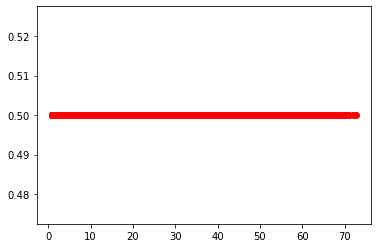

In [15]:
respiration = np.asarray([], dtype = "float")
bw_feature = np.asarray([], dtype = "float")
am_feature = np.asarray([], dtype = "float")
fm_feature = np.asarray([], dtype = "float")
diff = np.asarray([], dtype = "float")

print(onlydirs)
for j in range(len(onlydirs)-1,0,-1):

    print(onlydirs[j])
    csvpath = dataset_path+'/'+onlydirs[j]+'/Triggers.txt'
    info = np.loadtxt(csvpath,dtype='str')


    if(info[0][0] == 'BIOFEEDBACK-HRV-TRAININGS'):
            info = np.delete(info, 0, 0)

    val = False
    for k in range(len(info)):
        if(info[k][0] == 'BIOFEEDBACK-OXYGEN-TRAININGS'):
            val = True
            break

    if (val == True):
        info = np.delete(info, k, 0)


    print(info)
    print(np.shape(info))
    RR, RR_time = RR_data(j)

    print(np.shape(RR_time))

    for i in range(0,len(info)-1):
        
        print(info[i][0])

        min_time = float(info[i][1])
        max_time = float(info[i][2])
        #print(min_time, max_time)

        min_ind, max_ind = clip_range(j,i,RR_time, min_time, max_time)
        #print(min_ind, max_ind)
        RR_function = generate_RR(j, i, min_ind, max_ind, RR)

        rr = measure_RR(RR_function, True)

        ecg = generate_ecg(j,i, min_ind, max_ind)
        rr_bw = generate_bw(j, i, ecg)
        rr_am = generate_am(j,i,ecg)
        rr_fm = generate_fm(j,i,ecg)
        
        #diff = np.append(diff, np.abs(rr_bw-rr))

        respiration = np.append(respiration, rr)
        bw_feature = np.append(bw_feature, rr_bw)
        am_feature = np.append(am_feature, rr_am)
        fm_feature = np.append(fm_feature, rr_fm)

        print(j,i)

                

        

In [16]:
print(np.shape(am_feature))
features  = np.vstack((bw_feature, am_feature, fm_feature, respiration))

print(np.shape(features))

df = pd.DataFrame((features.T))
df.to_csv("features_Respiratory.csv")




(951,)
(4, 951)


(951, 3)
(951,)
(637, 3)
Coefficients: 
 [0.08620054 0.12541424 0.43654542]


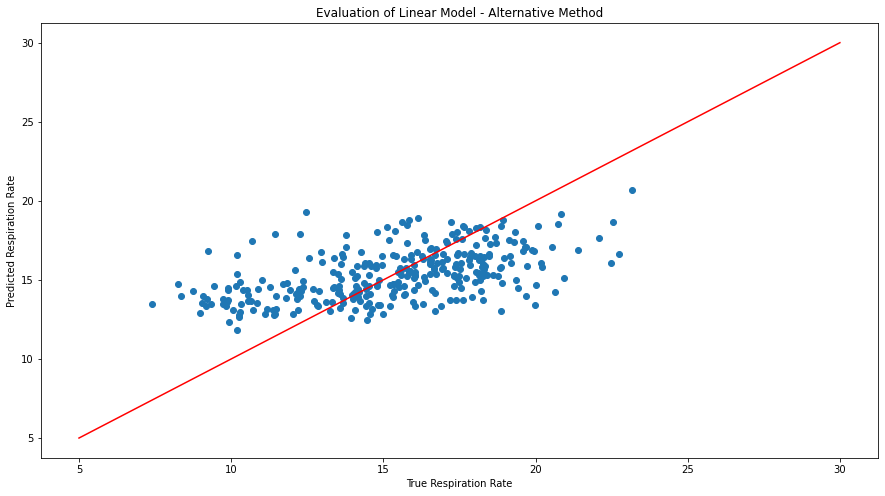

2.6660282256725654


In [36]:
## NEW LINEAR MODEL


from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('features_Respiratory.csv')
df.head(20)


features_in = df.to_numpy()[:,1:4]
print(np.shape(features_in))

rr_out = df.to_numpy()[:,4:5].flatten()
print(np.shape(rr_out))


X_train, X_test, y_train, y_test = train_test_split(features_in, rr_out, test_size=0.33, shuffle = True, random_state=42)



print(np.shape(X_train))

regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)

x = np.linspace(5,30,100)
y = x
plt.figure(figsize=(15,8))
plt.title('Evaluation of Linear Model - Alternative Method')
plt.plot(x, y, '-r',label = "Idea Scatter Plot Line")
plt.xlabel("True Respiration Rate")
plt.ylabel("Predicted Respiration Rate")
plt.scatter(y_test, y_pred)
plt.savefig("Improved Lineaer Model.png")
plt.show()


rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(rmse)


(1063, 4)
(1063,)
(850, 4)
Coefficients: 
 [ 0.0003287   0.00457852  0.08121092 -0.05742781]


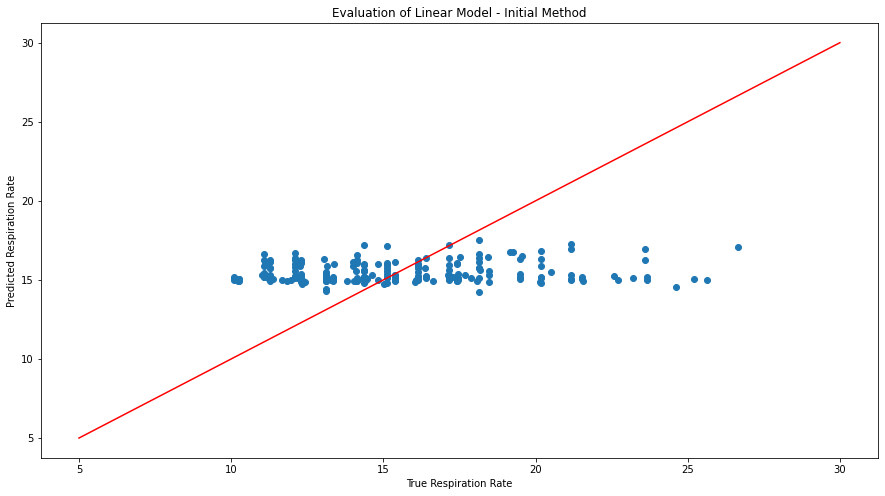

3.4321406449579643


In [58]:
## OLD LINEAR MODEL

df = pd.read_csv('model_features_RR_old.csv')
df.head(20)


features_in = df.to_numpy()[:,::2]
print(np.shape(features_in))

rr_out = df.to_numpy()[:,7:8].flatten()
print(np.shape(rr_out))


X_train, X_test, y_train, y_test = train_test_split(features_in, rr_out, test_size=0.2, shuffle = True, random_state=42)



print(np.shape(X_train))

regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)

x = np.linspace(5,30,100)
y = x
plt.figure(figsize=(15,8))
plt.title('Evaluation of Linear Model - Initial Method')
plt.plot(x, y, '-r',label = "Idea Scatter Plot Line")
plt.xlabel("True Respiration Rate")
plt.ylabel("Predicted Respiration Rate")
plt.scatter(y_test, y_pred)
plt.savefig("Bad Lineaer Model.png")
plt.show()


rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(rmse)


In [8]:
## BiLSTM MODEL

from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import TimeDistributed
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import pandas as pd
import numpy as np
 

#df = pd.read_csv('model_features_RR.csv')
df = pd.read_csv('features_Respiratory.csv')

#Data as inputs to the model
features = df.to_numpy()[:,1:5]



#scale_rr = preprocessing.StandardScaler().fit(rr_out)
#rr_out = scale_rr.transform(rr_out)

features_in, rr_out = features[:, 0:3], features[:, 3]
print(features_in)
features_in = features_in.reshape((len(features_in), 1, 3))


X_train, X_test, y_train, y_test = train_test_split(features_in, rr_out, test_size=0.33, random_state=42)



print(np.shape(X_train))


# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=256, return_sequences=True), input_shape=(1, 3), merge_mode = "concat"))
model.add(Bidirectional(LSTM(units=128, return_sequences=True), merge_mode = "concat"))
model.add(Bidirectional(LSTM(units=64,  return_sequences=False), merge_mode = "concat"))
model.add(Dense(units=1))

# Compile the model

model.compile(optimizer="adam", loss='mse')

# Train the model
model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=3, verbose = 1)
loss_df = pd.DataFrame(model.history.history)

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

loss_df.plot(figsize=(12,8))

#y_test = scale_rr.inverse_transform(y_test)
#predictions = scale_rr.inverse_transform(predictions)


[[15.23100355 18.19713564  7.04579768]
 [14.58670989 16.13522858  8.16961681]
 [13.63016811 16.5549862   5.86366968]
 ...
 [16.3902439  12.77336946  5.49702245]
 [13.87818042 18.17149347  7.29927007]
 [19.07032181 13.87015989  6.52741514]]
(637, 1, 3)


2023-05-25 14:50:41.140081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 14:50:41.147318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 14:50:41.150779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-05-25 14:50:44.467466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 14:50:44.470883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 14:50:44.473762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 24/213 [==>...........................] - ETA: 5s - loss: 138.1919

KeyboardInterrupt: 

[[15.23100355 18.19713564  7.04579768]
 [14.58670989 16.13522858  8.16961681]
 [13.63016811 16.5549862   5.86366968]
 ...
 [16.3902439  12.77336946  5.49702245]
 [13.87818042 18.17149347  7.29927007]
 [19.07032181 13.87015989  6.52741514]]
[[15.23100355 18.19713564  7.04579768]
 [14.58670989 16.13522858  8.16961681]
 [13.63016811 16.5549862   5.86366968]
 ...
 [16.3902439  12.77336946  5.49702245]
 [13.87818042 18.17149347  7.29927007]
 [19.07032181 13.87015989  6.52741514]]
Epoch 1/100
5/5 [==============================] - 2s 66ms/step - loss: 102.3895 - val_loss: 9.8398
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 15.6045 - val_loss: 13.4856
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 14.9706 - val_loss: 14.0477
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 15.9665 - val_loss: 9.3064
Epoch 5/100
5/5 [==============================] - 0s 27ms/step - loss: 11.1630 - val_loss: 10.4366
Epoch 6/100
5/5 [====

<Axes: >

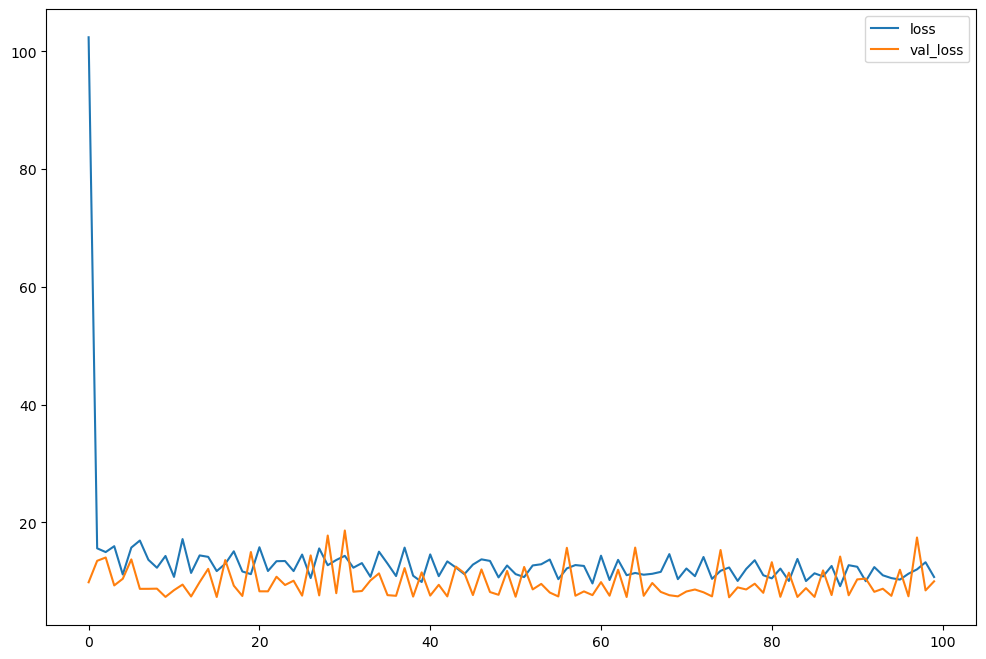

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import keras as keras

#df = pd.read_csv('model_features_RR.csv')
df = pd.read_csv('features_Respiratory.csv')

#Data as inputs to the model
features_in = df.to_numpy()[:,1:4]
rr_out = df.to_numpy()[:,4:5]

print(features_in)



#scale_rr = preprocessing.StandardScaler().fit(rr_out)
#rr_out = scale_rr.transform(rr_out)

print(features_in)


X_train, X_test, y_train, y_test = train_test_split(features_in, rr_out, test_size=0.33, random_state=42)



# Initializing a sequential neural network model
NNmodel = Sequential()

# Creating input and hidden layers, with activation fucntion ReLU
NNmodel.add(Dense(79,activation='relu'))
NNmodel.add(Dense(200,activation='relu'))

# Applying dropout regularization
NNmodel.add(Dropout(.05))

NNmodel.add(Dense(160,activation='relu'))
NNmodel.add(Dense(120,activation='relu'))
NNmodel.add(Dropout(.05))

NNmodel.add(Dense(80,activation='relu'))
NNmodel.add(Dense(40,activation='relu'))
NNmodel.add(Dropout(.05))

NNmodel.add(Dense(1))

# Compiling the model, and evaluating it using the MSE cost function
NNmodel.compile(loss='mean_squared_error')

# Testing the model
NNmodel.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100, batch_size=128)

# Storing the training and validation loss values 
loss_df = pd.DataFrame(NNmodel.history.history)

# Plotting the training and validation loss values
loss_df.plot(figsize=(12,8))

#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])

In [12]:
y_pred = NNmodel.predict(X_test)
y_pred= y_pred.reshape(-1,1)

10/10 [==============================] - 0s 2ms/step


RMSE of Neural Network: 3.1623448845666844


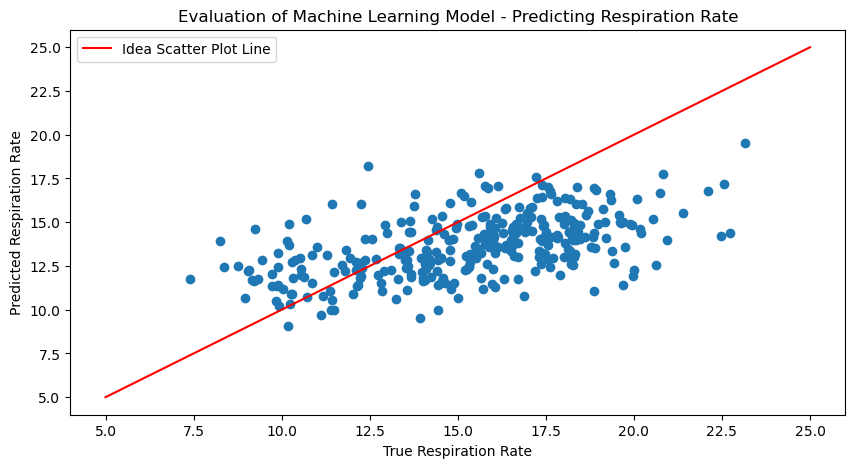

In [24]:
# Visualizing Our predictions
import matplotlib.pyplot as plt
from sklearn import metrics


fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
print('RMSE of Neural Network:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


x = np.linspace(5,25,100)
y = x
plt.title('Evaluation of Machine Learning Model - Predicting Respiration Rate')
plt.plot(x, y, '-r',label = "Idea Scatter Plot Line")
plt.xlabel('True Respiration Rate')
plt.legend()
plt.ylabel('Predicted Respiration Rate')
plt.savefig("RR result.png")
plt.show()